# MULTI-STRATEGY (FUNDS)

In [8]:
from __future__ import print_function
from IPython.utils.path import get_ipython_dir
print(get_ipython().profile_dir.location)

import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import itable
import ffn

from fintools.Parameters import Parameters
from fintools.set_start_end import set_start_end
from fintools.get_yahoo_prices import get_yahoo_prices
from fintools.compute_weights_RS_DM import compute_weights_RS_DM
from fintools.compute_weights_PMA import compute_weights_PMA
from fintools.endpoints import endpoints
from fintools.backtest import backtest
from fintools.monthly_return_table import monthly_return_table
from fintools.show_return_table import show_return_table
from fintools.finhelpers3 import highlight_pos_neg
from fintools import generate_orders

%matplotlib inline

/home/scubamut/.ipython/profile_default


# Portfolio Moving Average (PMA), Relative Strength (RS) and Dual Momentum (DM) Backtests

In [10]:
# Define which online source one should use
data_source = 'yahoo'

# We would like all available data from 01/01/2000 until today.

start_date = '1986-01-01'
# start_date = '2000-01-01'
# end_date = '2016-12-31'
end_date = datetime.today().strftime('%Y-%m-%d')

strategies = {
    'RS0001': { 'symbols': ['VCVSX','VWEHX','VFIIX','FGOVX','VWAHX'], 
               'prices':data_source, 'start':start_date, 'end':end_date,
               'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 2, 'frequency': 'M',
              'cash_proxy': 'CASHX', 'risk_free': 0},
    'RS0002': {'symbols': ['MMHYX','FAGIX','VFIIX'], 
               'prices':data_source, 'start':start_date, 'end':end_date,               
               'rs_lookback': 3, 'risk_lookback': 2, 'n_top': 1, 'frequency': 'M',
              'cash_proxy': 'CASHX', 'risk_free': 0},
    'RS0003': {'symbols': ['MMHYX','FAGIX','VFIIX'], 
               'prices':data_source, 'start':start_date, 'end':end_date,
               'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 1, 'frequency': 'Q',
              'cash_proxy': 'CASHX', 'risk_free': 0},    
    'DM0001': {'symbols': ['VCVSX','VWINX','VWEHX','VGHCX','VUSTX','VFIIX','VWAHX','FGOVX','FFXSX'], 
               'prices':data_source, 'start':start_date, 'end':end_date,
               'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 3, 'frequency': 'M',
              'cash_proxy': 'CASHX', 'risk_free': 'FFXSX'},
    'DM0002': {'symbols': ['VCVSX','VUSTX','VWEHX','VFIIX','VGHCX','FRESX'], 
               'prices':data_source, 'start':start_date, 'end':end_date,
               'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 5, 'frequency': 'M',
              'cash_proxy': 'VFIIX', 'risk_free': 'FFXSX'},
    'PMA001': {'symbols': ['VCVSX', 'VFIIX'], 
               'prices':data_source, 'start':start_date, 'end':end_date,  
               'risk_lookback': 3, 'frequency': 'M', 'allocations': [0.6, 0.4],
              'cash_proxy': 'VUSTX'},
    'PMA002': {'symbols': ['VCVSX', 'VWINX', 'VWEHX'], 
               'prices':data_source, 'start':start_date, 'end':end_date,
               'risk_lookback': 3, 'frequency': 'M', 'allocations': [0.6, 0.2, 0.2],
              'cash_proxy': 'VUSTX'},
    'PMA003': {'symbols': ['VCVSX', 'FAGIX', 'VGHCX'], 
               'prices':data_source, 'start':start_date, 'end':end_date,
               'risk_lookback': 2, 'frequency': 'M', 'allocations': [1./3., 1./3., 1./3.],
              'cash_proxy': 'VUSTX'}
    }

strategy_values = pd.DataFrame(columns=strategies.keys())
security_weights = {}
security_holdings = {}
prices = {}

for name in strategies :
    if 'PMA' in name :
        try:
            s_value, s_holdings, s_weights, s_prices =  compute_weights_PMA (name, strategies[name])
        except:
            print ('*** Unable to use PMA strategy : ' + name)
            name = 'None'
    else :
        try:
            s_value, s_holdings, s_weights, s_prices =  compute_weights_RS_DM (name, strategies[name])
        except:
            print ('*** Unable to use RS_DM strategy : ' + name)
            name = 'None'
            
    if name != 'None':
        strategy_values[name] = s_value
        security_weights[name] = s_weights
        security_holdings[name] = s_holdings
        prices[name] = s_prices

Strategy : RS0001
FIRST BUY DATE = 1986-07-31 00:00:00

Strategy : RS0002
FIRST BUY DATE = 1986-03-31 00:00:00

Strategy : RS0003
FIRST BUY DATE = 1986-03-31 00:00:00

Strategy : DM0001
FIRST BUY DATE = 1986-12-31 00:00:00

Strategy : DM0002
FIRST BUY DATE = 1986-12-31 00:00:00

PMA001
FIRST BUY DATE = 1986-08-29 00:00:00

PMA002
FIRST BUY DATE = 1986-08-29 00:00:00

PMA003
FIRST BUY DATE = 1986-07-31 00:00:00



In [11]:
index = strategy_values.dropna().index
rebalance_dates = endpoints(period='M', trading_days=index)

In [12]:
# find the set of all portfolio symbols
n = len(strategies)
l = [list(security_weights[name].columns) for name in strategies]
s = []
for i in range(n) :
    s = s + l[i]
    
aggregated_weights = pd.DataFrame(0, index=rebalance_dates, columns=list(set(s)))
all_prices = pd.DataFrame(0, index=index, columns=list(set(s)))
aggregated_weights[:1]

,VWAHX,VFIIX,FGOVX,MMHYX,FRESX,VGHCX,VWEHX,VWINX,VCVSX,VUSTX,FAGIX,CASHX,FFXSX
1986-12-31,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# for equally weighted strategies
strategy_weights = pd.Series([1. / n for i in range(n)], index=list(strategies.keys()))
strategy_weights

RS0001    0.125
RS0002    0.125
RS0003    0.125
DM0001    0.125
DM0002    0.125
PMA001    0.125
PMA002    0.125
PMA003    0.125
dtype: float64

In [14]:
for name in strategies :
    aggregated_weights[security_weights[name].columns] += security_weights[name].loc[rebalance_dates] * strategy_weights[name]
    all_prices = prices[name].loc[index].combine_first(all_prices)

In [15]:
aggregated_weights[:3].round(3)

,VWAHX,VFIIX,FGOVX,MMHYX,FRESX,VGHCX,VWEHX,VWINX,VCVSX,VUSTX,FAGIX,CASHX,FFXSX
1986-12-31,0.000,0.479,0.0,0.0,0.000,0.000,0.154,0.000,0.000,0.367,0.000,0.0,0.0
1987-01-30,0.062,0.325,0.0,0.0,0.025,0.108,0.050,0.067,0.321,0.000,0.042,0.0,0.0
1987-02-27,0.000,0.175,0.0,0.0,0.025,0.108,0.154,0.025,0.321,0.025,0.167,0.0,0.0


In [16]:
# from backtest_helpers.backtest import backtest
p_value, p_holdings, p_weights = backtest(all_prices, aggregated_weights, 10000., offset=0, commission=10.)

FIRST BUY DATE = 1986-12-31 00:00:00



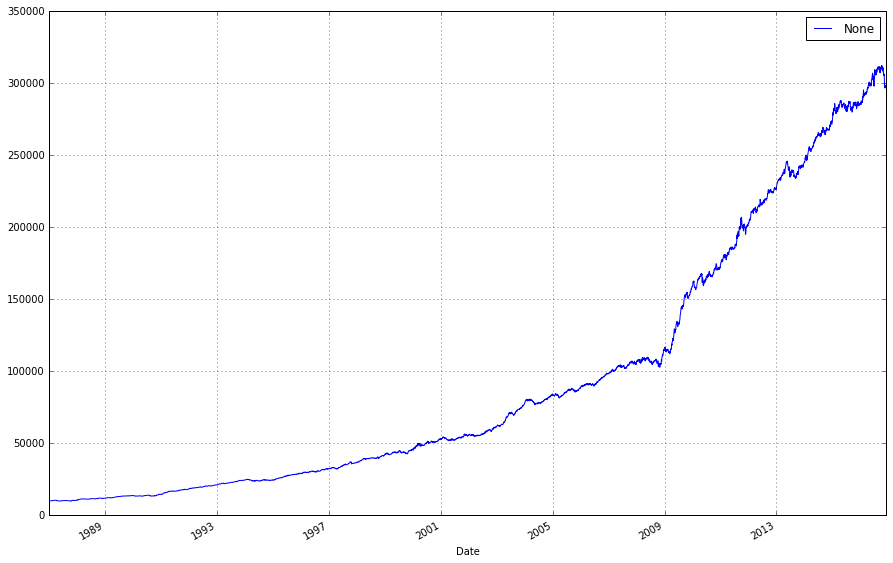

In [9]:
p_value.plot(figsize=(15,10), grid=True, legend=True)

In [17]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 1986-12-31 00:00:00 - 2018-08-10 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
3054.96%            2.25  11.54%  -6.90%

Annualized Returns:
mtd    3m     6m     ytd    1y     3y     5y     10y     incep.
-----  -----  -----  -----  -----  -----  -----  ------  --------
0.32%  1.72%  4.31%  1.28%  4.36%  4.55%  6.76%  11.61%  11.54%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  2.25     2.10       1.56
mean    11.04%   11.09%     11.62%
vol     4.92%    5.27%      7.45%
skew    -0.07    0.13       1.29
kurt    4.75     0.81       2.47
best    3.09%    6.40%      35.63%
worst   -2.85%   -3.52%     0.17%

Drawdowns:
max     avg       # days
------  ------  --------
-6.90%  -0.67%     15.86

Misc:
---------------  -------
avg. up month    1.55%
avg. down month  -0.96%
up year %        100.00%
12m up %         97.84%
--

In [18]:
def highlight_pos_neg (s) :
    is_positive = s > 0    
    return ['background-color : rgb(127,255,0)' if v else 'background-color : rgb(255,99,71)' for v in is_positive]

df = monthly_return_table (p_value)

df.style.\
    apply(highlight_pos_neg)

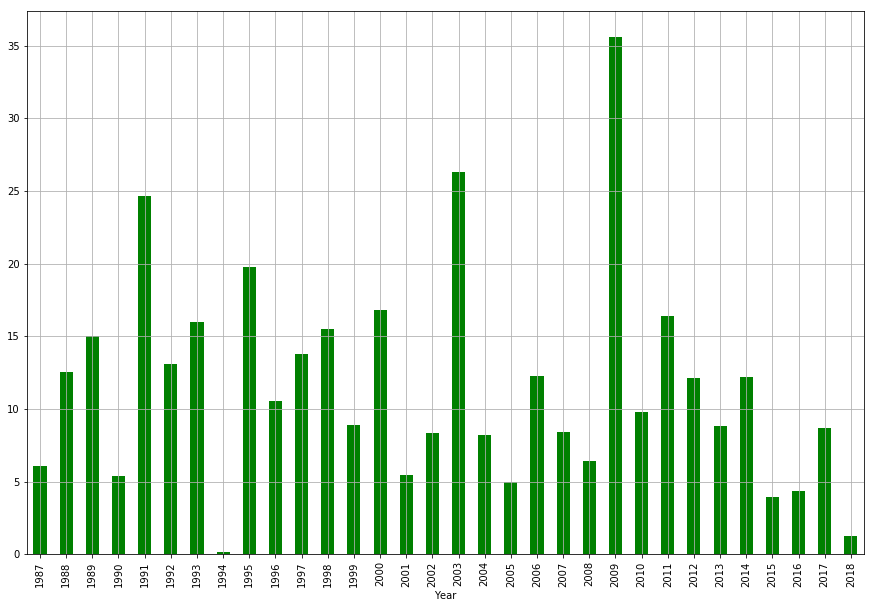

In [19]:
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

### Need to determine the holdings of each security

In [20]:
p_holdings.loc[rebalance_dates].round(0)[:5]

,CASHX,FAGIX,FFXSX,FGOVX,FRESX,MMHYX,VCVSX,VFIIX,VGHCX,VUSTX,VWAHX,VWEHX,VWINX
Date,,,,,,,,,,,,,
1986-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2980.0,0.0,2930.0,0.0,2315.0,0.0
1987-01-30,0.0,591.0,0.0,0.0,122.0,0.0,2675.0,2022.0,384.0,0.0,354.0,743.0,333.0
1987-02-27,0.0,2401.0,0.0,0.0,123.0,0.0,2595.0,1105.0,389.0,203.0,0.0,2305.0,128.0
1987-03-31,0.0,4192.0,185.0,0.0,122.0,0.0,2270.0,477.0,377.0,208.0,0.0,2304.0,0.0
1987-04-30,3799.0,1787.0,0.0,0.0,0.0,0.0,0.0,801.0,0.0,3174.0,0.0,0.0,0.0


In [21]:
transactions = (p_holdings - p_holdings.shift(1).fillna(0))
transactions = transactions[transactions.sum(1) != 0]
transactions.round(0)[:5]

,CASHX,FAGIX,FFXSX,FGOVX,FRESX,MMHYX,VCVSX,VFIIX,VGHCX,VUSTX,VWAHX,VWEHX,VWINX
Date,,,,,,,,,,,,,
1986-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2980.0,0.0,2930.0,0.0,2315.0,0.0
1987-01-30,0.0,591.0,0.0,0.0,122.0,0.0,2675.0,-958.0,384.0,-2930.0,354.0,-1572.0,333.0
1987-02-27,0.0,1810.0,0.0,0.0,1.0,0.0,-81.0,-917.0,5.0,203.0,-354.0,1562.0,-206.0
1987-03-31,0.0,1790.0,185.0,0.0,-2.0,0.0,-324.0,-627.0,-11.0,5.0,0.0,-1.0,-128.0
1987-04-30,3799.0,-2405.0,-185.0,0.0,-122.0,0.0,-2270.0,324.0,-377.0,2966.0,0.0,-2304.0,0.0


In [26]:
# del transactions['CASHX']
orders = generate_orders(transactions, all_prices)
orders[:10]

,Year,Month,Day,Symbol,Action,Qty,Price
0,1986,12,31,VFIIX,Buy,2980.029547,1.607926
0,1986,12,31,VUSTX,Buy,2929.662092,1.251566
0,1986,12,31,VWEHX,Buy,2315.213444,0.665885
0,1987,1,30,FAGIX,Buy,591.376772,0.714250
0,1987,1,30,FRESX,Buy,122.413701,2.070311
0,1987,1,30,VCVSX,Buy,2675.067173,1.215823
0,1987,1,30,VFIIX,Sell,958.495612,1.629776
0,1987,1,30,VGHCX,Buy,383.818747,2.861288
0,1987,1,30,VUSTX,Sell,2929.662092,1.263704
0,1987,1,30,VWAHX,Buy,353.731370,1.791150


### Let's look at some more recent performance

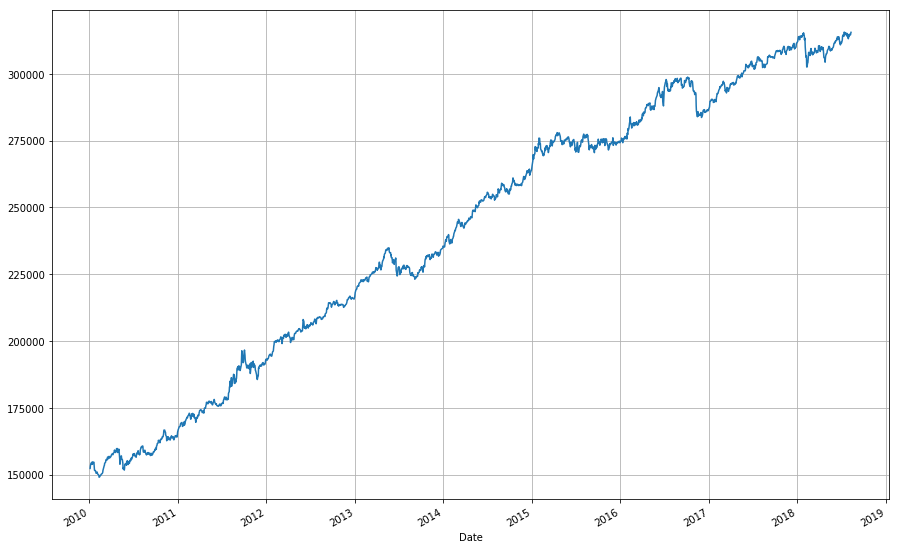

In [27]:
import datetime as dt
p_value[p_value.index > dt.datetime(2010,1,1)].plot(figsize=(15,10), grid=True)

#### What about using downside protection?

In [35]:
cash_proxy = 'FFXSX'
risk_free = 'FFXSX'

if risk_free == 'CASHX' :
    px = pd.DataFrame (columns=list(set([cash_proxy, risk_free])))
    tickers = [cash_proxy]
elif isinstance (risk_free, str) :
    px =  pd.DataFrame (columns=list(set([cash_proxy, risk_free])))
    tickers = [cash_proxy, risk_free]
else :
    px = pd.DataFrame (columns=[cash_proxy])

prices = strategy_values.copy().dropna()
prices = prices / prices.iloc[0]
for symbol in tickers :
#     url = 'http://chart.finance.yahoo.com/table.csv?s=' + symbol + '&ignore=.csv'
#     prices[symbol] = pd.read_csv(url, parse_dates=True, index_col='Date').sort_index(ascending=True)['Adj Close'] 
       prices[symbol] = web.DataReader(tickers, data_source, start_date, end_date)['Adj Close']
prices = prices.dropna()
symbols = prices.columns

In [36]:
prices[:3]

,RS0001,RS0002,RS0003,DM0001,DM0002,PMA001,PMA002,PMA003,FFXSX
Date,,,,,,,,,
1986-12-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.324906
1987-01-02,1.001041,1.000995,1.000995,1.002645,1.001985,1.003910,1.004900,1.005854,2.324906
1987-01-05,1.002625,1.001990,1.001990,1.004352,1.003407,1.005479,1.006896,1.007805,2.324906


In [19]:
prices[:3]

,RS0001,PMA003,RS0002,PMA001,PMA002,DM0001,RS0003,DM0002,FFXSX
Date,,,,,,,,,
1986-12-31,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.379192
1987-01-02,1.001041,1.005854,1.000995,1.003911,1.004901,1.002646,1.000097,1.001986,2.379192
1987-01-05,1.002626,1.007805,1.001990,1.005479,1.006896,1.004352,1.001075,1.003407,2.379192


              RS0001    RS0002    RS0003    DM0001    DM0002    PMA001  \
Date                                                                     
1987-01-30  0.111111  0.111111  0.111111  0.111111  0.111111  0.111111   
1987-02-27  0.111111  0.111111  0.111111  0.111111  0.111111  0.111111   
1987-03-31  0.111111  0.111111  0.000000  0.111111  0.111111  0.000000   
1987-04-30  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1987-05-29  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

              PMA002    PMA003     FFXSX  
Date                                      
1987-01-30  0.111111  0.111111  0.111111  
1987-02-27  0.111111  0.111111  0.111111  
1987-03-31  0.000000  0.111111  0.444444  
1987-04-30  0.000000  0.000000  1.000000  
1987-05-29  0.000000  0.000000  1.000000  
FIRST BUY DATE = 1987-01-30 00:00:00



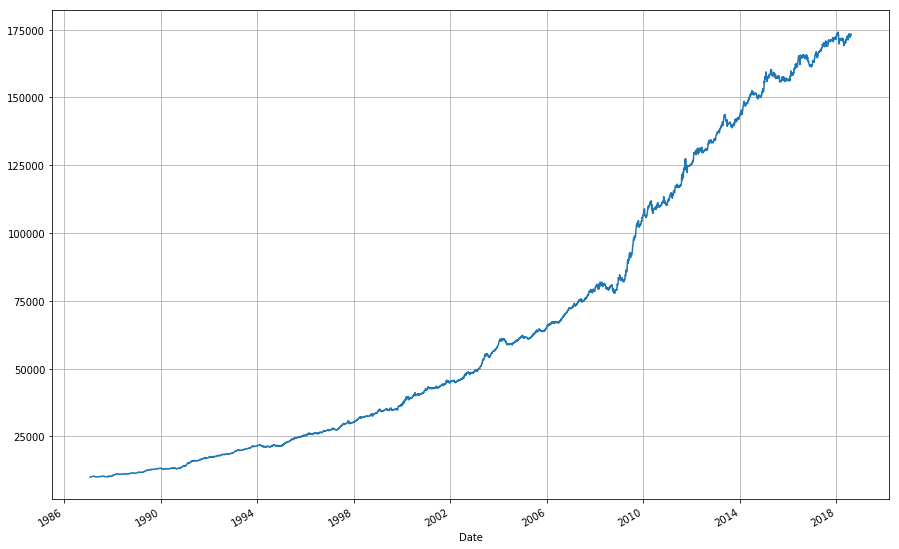

In [37]:
rs_lookback = 1
risk_lookback = 1
n_top = len(symbols)

frequency = 'M'

end_points = endpoints(period=frequency, trading_days=prices.index)
prices_m = prices.loc[end_points]

returns = prices_m[symbols].pct_change(rs_lookback)[rs_lookback:]
absolute_momentum_rule = returns > 0

if isinstance(risk_free, int) :
    excess_returns = returns
else :
    risk_free_returns =  prices_m[risk_free].pct_change(rs_lookback)[rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()

rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

# relative strength ranking               
ranked = excess_returns.loc[rebalance_dates][symbols].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked<=n_top] > 0

# equal weight allocations
elligible = elligible.multiply(1./elligible.sum(1), axis=0)

# downside protection
weights = pd.DataFrame(0.,index=elligible.index, columns=prices.columns)
if cash_proxy == 'CASHX' :
    weights[cash_proxy] = 0
    prices[cash_proxy] = 1.
weights[symbols] = (elligible * absolute_momentum_rule).dropna() 
weights[cash_proxy] += 1 - weights[symbols].sum(axis=1)

print (weights[:5])

# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

The CAGR has dropped slightly but the Sharpe Ratio has increased significantly and the Max Drawdown has been reduced

In [38]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 1987-01-30 00:00:00 - 2018-08-10 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
1633.19%            2.31  9.47%   -4.88%

Annualized Returns:
mtd    3m     6m     ytd    1y     3y     5y     10y    incep.
-----  -----  -----  -----  -----  -----  -----  -----  --------
0.26%  1.74%  2.12%  0.57%  2.63%  3.28%  4.27%  8.08%  9.47%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  2.31     2.17       1.51
mean    9.12%    9.15%      9.64%
vol     3.95%    4.21%      6.39%
skew    -0.03    0.32       1.07
kurt    4.78     1.06       1.25
best    1.57%    4.90%      28.21%
worst   -2.49%   -2.68%     0.22%

Drawdowns:
max     avg       # days
------  ------  --------
-4.88%  -0.56%     17.07

Misc:
---------------  -------
avg. up month    1.21%
avg. down month  -0.75%
up year %        100.00%
12m up %         98.37%
-------

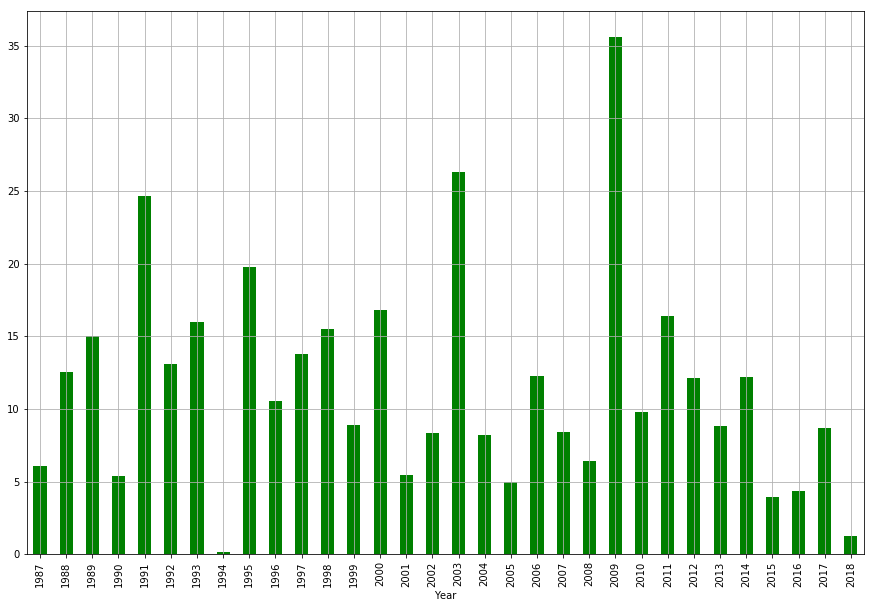

In [39]:
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

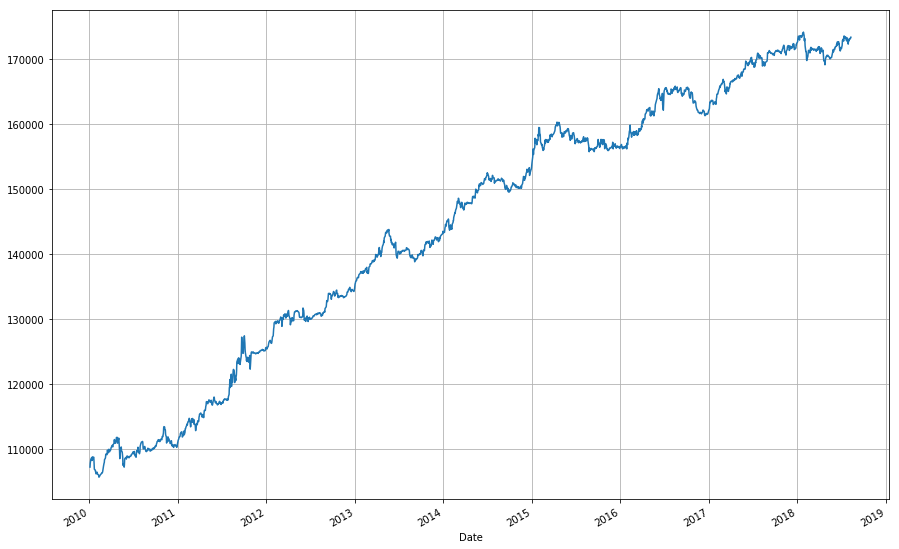

In [40]:
p_value[p_value.index > dt.datetime(2010,1,1)].plot(figsize=(15,10), grid=True)

In [41]:
p_holdings.loc[rebalance_dates].round(0)[:5]

,RS0001,RS0002,RS0003,DM0001,DM0002,PMA001,PMA002,PMA003,FFXSX
Date,,,,,,,,,
1987-01-30,1091.0,1096.0,1096.0,1094.0,1095.0,1099.0,1097.0,1100.0,474.0
1987-02-27,1082.0,1110.0,1110.0,1093.0,1094.0,1082.0,1081.0,1097.0,483.0
1987-03-31,1084.0,1107.0,0.0,1083.0,1090.0,0.0,0.0,1086.0,1940.0
1987-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4317.0
1987-05-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4317.0


this is not very helpful - we need to know what to order at each rebalance date

In [42]:
p_weights.loc[rebalance_dates].round(3)[:5]

,RS0001,RS0002,RS0003,DM0001,DM0002,PMA001,PMA002,PMA003,FFXSX
Date,,,,,,,,,
1987-01-30,0.111,0.111,0.111,0.111,0.111,0.111,0.111,0.111,0.111
1987-02-27,0.111,0.111,0.111,0.111,0.111,0.111,0.111,0.111,0.111
1987-03-31,0.111,0.111,0.000,0.111,0.111,0.000,0.000,0.111,0.444
1987-04-30,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
1987-05-29,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000


In [43]:
portfolios = {'DM0001': {'symbols': list(strategies), 'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 3, 'frequency': 'm', 'cash_proxy': 'CASHX', 'risk_free': 'FFXSX'}}
              
p_value1, p_holdings1, p_weights1, prices1 =  compute_weights_RS_DM ('DM0001', portfolios['DM0001'])
p_value1.plot(figsize=(10, 8), grid=True)

Strategy : DM0001


AttributeError: 'Parameters' object has no attribute 'prices'